# E -06 영화리뷰 텍스트 감성분석

### 1. 데이터로드

In [1]:
import pandas as pd
import missingno as msno

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 결측치 확인

<AxesSubplot:>

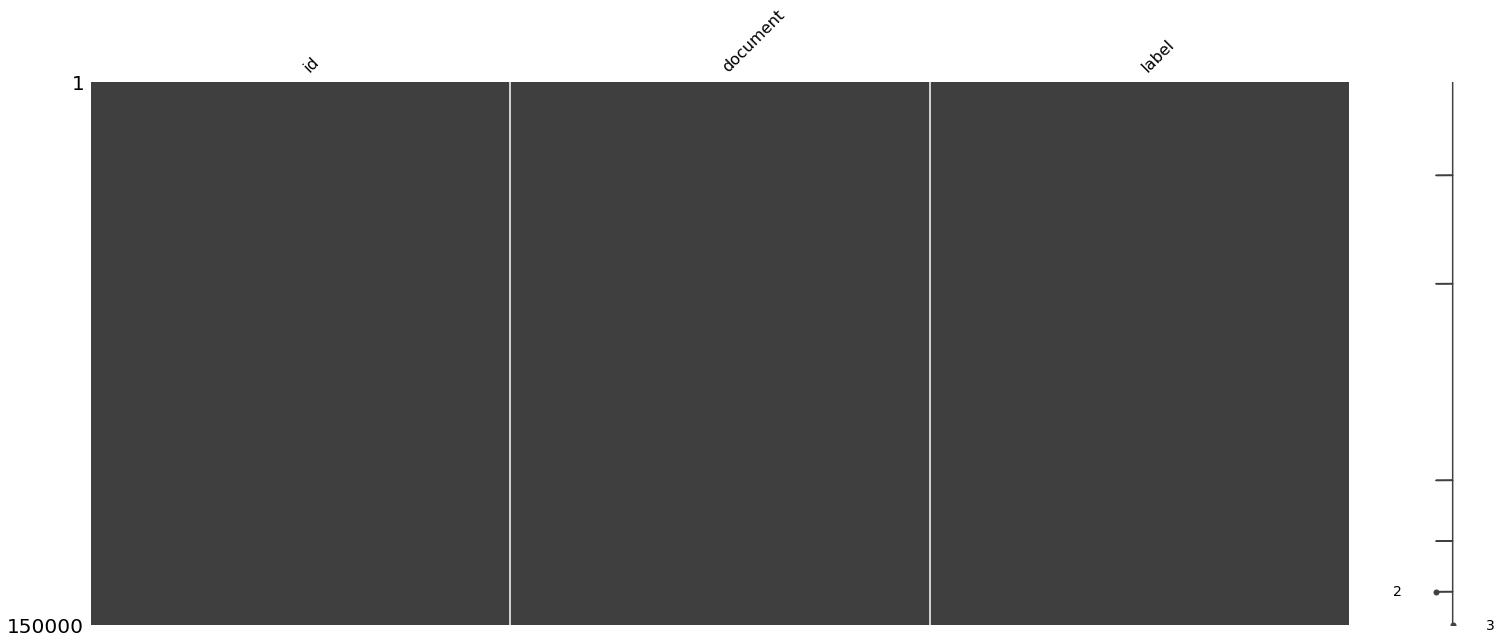

In [2]:
msno.matrix(train_data) #결측치 이미지로 확인

### 3. 데이터 전처리 (불용어,중복,결측치 제거)

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','.'] #.추가

def load_data(train_data, test_data, num_words=10000):
    #데이터 전처리  중복제거 -> 격측치 제거 (train , test )
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    #토큰화하면서 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    #concatenate를 이용해서 
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

Mecab tokenizer가 가장 좋다고한다. https://i-am-wendy.tistory.com/27 

In [1]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word)   


{3: '<UNUSED>', 4: '영화', 5: '다', 6: '고', 7: '하', 8: '을', 9: '보', 10: '..', 11: '게', 12: ',', 13: '!', 14: '지', 15: '있', 16: '없', 17: '?', 18: '좋', 19: '나', 20: '었', 21: '만', 22: '는데', 23: '너무', 24: '봤', 25: '적', 26: '안', 27: '정말', 28: '로', 29: '음', 30: '것', 31: '아', 32: '네요', 33: '재밌', 34: '어', 35: '같', 36: '점', 37: '지만', 38: '진짜', 39: '했', 40: '에서', 41: '기', 42: '네', 43: '않', 44: '거', 45: '았', 46: '수', 47: '되', 48: '면', 49: 'ㅋㅋ', 50: '말', 51: '연기', 52: '인', 53: '주', 54: '내', 55: '최고', 56: '~', 57: '평점', 58: '이런', 59: '던', 60: '어요', 61: '할', 62: '왜', 63: '겠', 64: '1', 65: '스토리', 66: '해', 67: '습니다', 68: 'ㅋㅋㅋ', 69: '...', 70: '드라마', 71: '생각', 72: '아니', 73: '더', 74: '그', 75: '싶', 76: '사람', 77: '듯', 78: '때', 79: '감동', 80: '함', 81: '배우', 82: '본', 83: '까지', 84: '뭐', 85: '알', 86: '만들', 87: '내용', 88: '볼', 89: '감독', 90: '보다', 91: '라', 92: '그냥', 93: '재미', 94: '시간', 95: '지루', 96: '중', 97: '재미있', 98: '년', 99: '10', 100: '였', 101: '잼', 102: '사랑', 103: '못', 104: '냐', 105: '재미없', 106: '쓰레기', 107: '서'

#### 토크나이저 함수를 통해 리뷰 글을 전처리하고 단어로 분리해서 사전을 만든다. 
#### word_to_index 단어:숫자 , index_to_word  숫자 : 단어 

### 4. 패딩에 적절한 길이 찾기

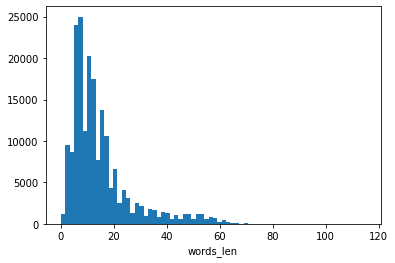

평균 :  14.882230378982179
표준편차 :  12.112488620375657
최대길이  115


In [6]:
import matplotlib.pyplot as plt
all_document = X_train + X_test
words_len=[]
for i in all_document :
    words_len.append([len(i)])

words_len= np.array(words_len)

plt.hist(words_len, bins=70, label='words_len')
plt.xlabel('words_len')
plt.show()

print("평균 : ", words_len.mean())
print("표준편차 : ",words_len.std())
print("최대길이 ", words_len.max())


#### 평균과 최대길이가 차이도 크지만 표본이 앞쪽에 몰려있어서 한 35정도를 maxlen을 잡았다.

In [8]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', 
                                                        maxlen=35)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=35)

print(X_train.shape)

(146182, 35)


# 5.모델만들기
- lms에 나온 3가지 RNN CNN GlobalMaxPooling1D() 레이어 하나만 사용하는 방법 

5.1 RNN

In [9]:

vocab_size = 10000
word_vector_dim = 32

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim , input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(16))
rnn_model.add(tf.keras.layers.Dense(16, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 323,553
Trainable params: 323,553
Non-trainable params: 0
_________________________________________________________________


5.2 CNN

In [10]:

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(16, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

5.3 1_GM

In [11]:
gm_model = tf.keras.Sequential()
gm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gm_model.add(tf.keras.layers.GlobalMaxPooling1D())
gm_model.add(tf.keras.layers.Dense(8, activation='relu'))
gm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


# 6. 모델 학습 및  평가

In [27]:
#모델 컴파일
rnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
gm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.25, verbose=1)

Epoch 1/20
215/215 [==============================] - 3s 8ms/step - loss: 0.2838 - accuracy: 0.8795 - val_loss: 0.3646 - val_accuracy: 0.8457
Epoch 2/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2679 - accuracy: 0.8848 - val_loss: 0.3704 - val_accuracy: 0.8470
Epoch 3/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2571 - accuracy: 0.8881 - val_loss: 0.3773 - val_accuracy: 0.8465
Epoch 4/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2440 - accuracy: 0.8944 - val_loss: 0.3906 - val_accuracy: 0.8450
Epoch 5/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2315 - accuracy: 0.8993 - val_loss: 0.4079 - val_accuracy: 0.8441
Epoch 6/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2202 - accuracy: 0.9057 - val_loss: 0.3975 - val_accuracy: 0.8444
Epoch 7/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2095 - accuracy: 0.9119 - val_loss: 0.4304 - val_accuracy: 0.8444
Epoch 

In [29]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.25, verbose=1)

Epoch 1/20
215/215 [==============================] - 3s 6ms/step - loss: 0.4638 - accuracy: 0.7832 - val_loss: 0.3573 - val_accuracy: 0.8430
Epoch 2/20
215/215 [==============================] - 1s 5ms/step - loss: 0.3194 - accuracy: 0.8654 - val_loss: 0.3450 - val_accuracy: 0.8502
Epoch 3/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2776 - accuracy: 0.8855 - val_loss: 0.3451 - val_accuracy: 0.8534
Epoch 4/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2352 - accuracy: 0.9073 - val_loss: 0.3751 - val_accuracy: 0.8475
Epoch 5/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1909 - accuracy: 0.9283 - val_loss: 0.4004 - val_accuracy: 0.8451
Epoch 6/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1447 - accuracy: 0.9491 - val_loss: 0.4574 - val_accuracy: 0.8357
Epoch 7/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1092 - accuracy: 0.9640 - val_loss: 0.5011 - val_accuracy: 0.8354
Epoch 

In [30]:
gm_history = gm_model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.25, verbose=1)

Epoch 1/20
215/215 [==============================] - 1s 4ms/step - loss: 0.5716 - accuracy: 0.7594 - val_loss: 0.4155 - val_accuracy: 0.8256
Epoch 2/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3604 - accuracy: 0.8466 - val_loss: 0.3581 - val_accuracy: 0.8435
Epoch 3/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3100 - accuracy: 0.8693 - val_loss: 0.3494 - val_accuracy: 0.8481
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2802 - accuracy: 0.8841 - val_loss: 0.3495 - val_accuracy: 0.8499
Epoch 5/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2564 - accuracy: 0.8962 - val_loss: 0.3557 - val_accuracy: 0.8497
Epoch 6/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2357 - accuracy: 0.9064 - val_loss: 0.3650 - val_accuracy: 0.8487
Epoch 7/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2169 - accuracy: 0.9152 - val_loss: 0.3776 - val_accuracy: 0.8472
Epoch 

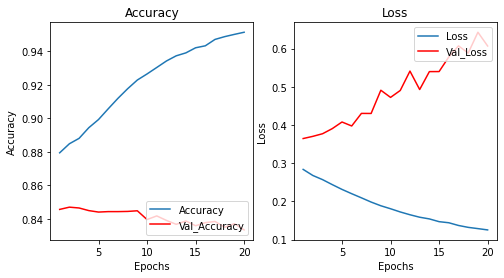

In [31]:
history_dict = rnn_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


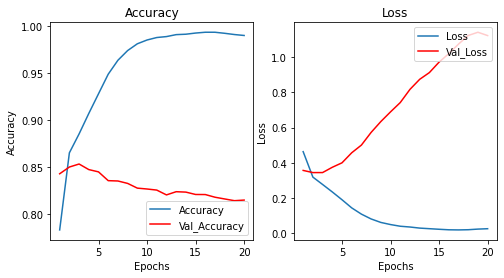

In [32]:
history_dict = cnn_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

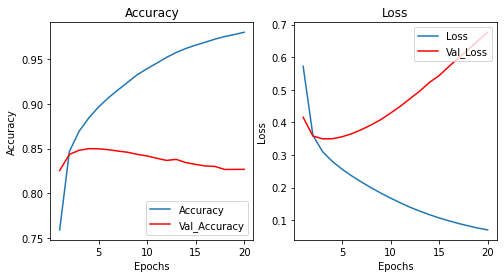

In [33]:
history_dict = gm_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# RNN, CNN , 1-GB 모델의 확인결과
## - epochs는 3 모델들의 epochs는 '5'가 적당해 보인다 5부터는 val loss가 커져버린다. (과적합)
## - val accuracy가 정확한건 RNN이고 loss도 5보다 작다. RNN이 가장 적합해보인다.

# 7. 학습된 Embedding 레이어 분석
### 7.1 학습 결과가 좋았던 RNN의 Embedding layer를 확인

In [24]:
rnn_embedding_layer = rnn_model.layers[0]
rnn_weights = rnn_embedding_layer.get_weights()[0]

# shape: (vocab_size, embedding_dim)
print(rnn_weights.shape)    


(10000, 32)


In [34]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)
vocab_size = rnn_weights.shape[0]
rnn_word_vector_dim = rnn_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, rnn_word_vector_dim))
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
rnn_vectors = rnn_model.get_weights()[0]
print(vocab_size)
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
f.close()

(10000, 32)


NameError: name 'rnn_weights' is not defined

In [32]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('귀여움', 0.9536675214767456),
 ('걸작', 0.9507961273193359),
 ('일품', 0.9453620314598083),
 ('최고', 0.9452052712440491),
 ('전국', 0.943719744682312),
 ('혹평', 0.9424390196800232),
 ('완벽', 0.9411464333534241),
 ('넘어서', 0.9401055574417114),
 ('풀어낸', 0.9390750527381897),
 ('봐야', 0.9387200474739075)]

In [33]:
word_vectors.similar_by_word("폭력")

[('자본주의', 0.8146066069602966),
 ('자리', 0.7673434019088745),
 ('걸까', 0.7553487420082092),
 ('스크림', 0.7460354566574097),
 ('쪙', 0.7347292304039001),
 ('그림', 0.7275503277778625),
 ('스파이', 0.7254571914672852),
 ('히', 0.7138295769691467),
 ('흐', 0.7097193598747253),
 ('군대', 0.6793245077133179)]

- 네이버 리뷰를 통한 얻은 워드 벡터이기 때문에 보편성은 적지만 어느정도 느낌은 가져간것같다.
- 폭력과 자본주의가 가장 유사성이 높다는게 재밌었다.
-  쪙과 히 흐 오 ㅏ같은 한 단어와 유사성을 가진다는게 마음에 안들었다. 하나의 글자는 토크나이즈할때 제거해주는것이 좋다고도 생각이든다.
- 에폭을 20까지 가져서 너무 과적합이 된 느낌도 든다 ->5로해보자


Epoch 1/5
215/215 [==============================] - 5s 8ms/step - loss: 0.5159 - accuracy: 0.7335 - val_loss: 0.3715 - val_accuracy: 0.8376
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3401 - accuracy: 0.8559 - val_loss: 0.3532 - val_accuracy: 0.8450
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3181 - accuracy: 0.8655 - val_loss: 0.3559 - val_accuracy: 0.8462
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3042 - accuracy: 0.8716 - val_loss: 0.3596 - val_accuracy: 0.8444
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2932 - accuracy: 0.8763 - val_loss: 0.3598 - val_accuracy: 0.8406


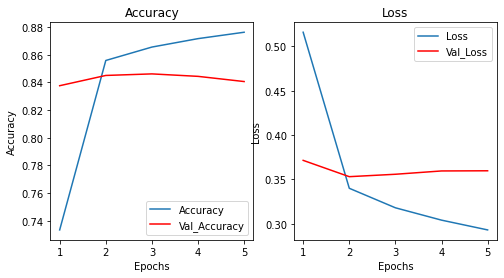

In [12]:
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim , input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(16))
rnn_model.add(tf.keras.layers.Dense(16, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
rnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.25, verbose=1)

history_dict = rnn_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [37]:
embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)
vocab_size = rnn_weights.shape[0]
rnn_word_vector_dim = rnn_weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, rnn_word_vector_dim))
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
rnn_vectors = rnn_model.get_weights()[0]
print(vocab_size)
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
f.close()

(10000, 32)
10000


In [39]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('훌륭', 0.911428689956665),
 ('캡틴', 0.9098734259605408),
 ('운명', 0.907923698425293),
 ('들이', 0.9023334980010986),
 ('틈', 0.901788055896759),
 ('똘', 0.9007565379142761),
 ('인게', 0.895138680934906),
 ('구하', 0.8943634033203125),
 ('멋지', 0.8943234086036682),
 ('걸작', 0.8922280669212341)]

In [40]:
word_vectors.similar_by_word("폭력")

[('이름', 0.6591795682907104),
 ('조폭', 0.6460614204406738),
 ('면', 0.6352239847183228),
 ('티비', 0.5996062755584717),
 ('괸', 0.5867893695831299),
 ('윌리스', 0.5758711099624634),
 ('일류', 0.5736408829689026),
 ('7', 0.5704350471496582),
 ('차별', 0.5690716505050659),
 ('어떻게', 0.5681570768356323)]

- 과적합을 줄이니 조금더 나아보인다.

### 7.2 Word2vec embedding layer 확인

In [45]:
!pip uninstall gensim --yes
!pip install gensim==3.8.3

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2
     |████████████████████████████████| 23.4 MB 7.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=adcc8fca3b8f32ac3f7160d39f3ea046fc7d5733116103263080f29dcce22865
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim


In [15]:
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec =Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector  # 200dim의 워드 벡터입니다.

/tmp/ipykernel_4184/1145711992.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [16]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_4184/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [17]:
word2vec.similar_by_word("폭력")

/tmp/ipykernel_4184/1368358279.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("폭력")


[('폭력적', 0.6629045605659485),
 ('성폭력', 0.599521815776825),
 ('테러리즘', 0.5860792398452759),
 ('성희롱', 0.5791626572608948),
 ('차별', 0.5683963894844055),
 ('억압', 0.5622648000717163),
 ('동성애', 0.561874270439148),
 ('혐오', 0.5593382120132446),
 ('소수자', 0.5560852289199829),
 ('무관심', 0.5544730424880981)]

### 리뷰를 통해 학습시킨 embedding층과 달리 보편적으로 비슷한 느낌의 단어들과 관련된 단어들이 벡터화 되어있는 것을 확인할수 잇다.

In [19]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_4184/613931723.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4184/613931723.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


ValueError: could not broadcast input array from shape (200,) into shape (32,)

embedding matrix의 shape가 (200,)인지 확인

In [22]:
#shape가 200이라 하니 word_vector_dim을 바꿔준다.
embedding_matrix = np.random.rand(vocab_size, 200) #200 embedding matrix크기

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_4184/2940591079.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4184/2940591079.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### 7.3 Word2vec의 Embedding 층으로 바꿔보기 (파인튜닝)

In [44]:
finetune_model = tf.keras.Sequential()
finetune_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 200, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=35, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
finetune_model.add(tf.keras.layers.LSTM(128))
finetune_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

finetune_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 35, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [48]:
finetune_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

finetune_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

f_history =finetune_model.fit(X_train,y_train, epochs=5, batch_size=512, validation_split=0.25, verbose=1)

Epoch 1/5
215/215 [==============================] - 5s 15ms/step - loss: 0.5923 - accuracy: 0.6470 - val_loss: 0.4279 - val_accuracy: 0.8080
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3659 - accuracy: 0.8389 - val_loss: 0.3436 - val_accuracy: 0.8508
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3053 - accuracy: 0.8689 - val_loss: 0.3311 - val_accuracy: 0.8595
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2723 - accuracy: 0.8867 - val_loss: 0.3333 - val_accuracy: 0.8592
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2443 - accuracy: 0.9001 - val_loss: 0.3325 - val_accuracy: 0.8610


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


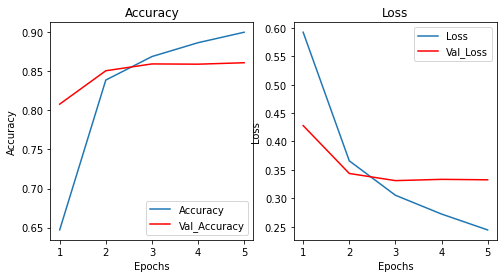

In [50]:
history_dict = f_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 8. 파인튜닝된 모델의 예측 확인
- #t1seo님의 코드를 인용했습니다!

In [57]:
tokenizer = Mecab()


def sentiment_predict(new_sentence):
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence.insert(0, '<BOS>')
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    new_sentence = wordlist_to_indexlist(new_sentence) # encoding
    new_sentence = [new_sentence]

    new_sentence = tf.keras.preprocessing.sequence.pad_sequences(new_sentence,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',
                                                    maxlen=35)
    
    score = float(finetune_model.predict(new_sentence)) # 예측
    
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [60]:
sentiment_predict('영화가 노잼')

89.61% 확률로 부정 리뷰입니다.



In [64]:
sentiment_predict('영화 너무 재밌어요!')

76.05% 확률로 긍정 리뷰입니다.



In [69]:
sentiment_predict('흥미진진한 전개, 스펙타클한 액션')

67.44% 확률로 부정 리뷰입니다.



In [68]:
sentiment_predict('압도적인 몰입감 즐기면서봤다')

62.28% 확률로 긍정 리뷰입니다.



# 회고

- word to index , index to word를 list comprehension을 통해 깔끔하게 만드는 법이 파이썬 문법적으로 잘배운것같다.
- 단어를 벡터화하는 Embedding layer라는 개념이 재미있었다. 벡터공간의 수를 어떻게 정해주는 기법을 더 알고싶다.
- finetuning을 통하여 시간을 절약하고, 프로젝트에서 데이터가 부족할때 어떻게 해야할지 잘 배운 것 같다.
- padding에 대한 길이 설정에서 임의로 설정을 했는데 일반적으로는 어떻게 설정을 하는지 찾아봐야할것같다.
- word2vec을 다운그레이드 하면서 확인을 했어야했는데, 조원 분들의 도움덕분에 쉽게한것같다. 감사하다